## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2
from keras.layers import Dropout
from keras.layers import BatchNormalization


def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], use_bn=True, drp_ratio=0, l2_ratio=0):
    
    # input layer
    input_layer = keras.layers.Input(input_shape)
    
    # hidden layer
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer) # regularization
            
            x = Dropout(drp_ratio)(x) # Dropput
            if use_bn:
                x = BatchNormalization()(x) # BatchNormalization
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x) # regularization
            x = Dropout(drp_ratio)(x) # Dropput
            if use_bn:
                x = BatchNormalization()(x) # BatchNormalization
    
    # output layer
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 256

MOMENTUM = 0.95
USE_BN = [True, False]
DRP_RATIO = [0, 0.25, 0.5, 0.8]
L2_RATIO = [0, 1e-2, 1e-4]

In [10]:
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
results = {}
for i, (use_bn, drp_ratio, l2_ratio) in enumerate(itertools.product(USE_BN, DRP_RATIO, L2_RATIO)):
    
    # clear_session
    #K.clear_session()
    
    # build model
    print("Numbers of exp: %i, with bn: %s, drp_ratio: %.2f, l2_ratio: %.2f" % (i, use_bn, drp_ratio, l2_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], use_bn=use_bn, drp_ratio=drp_ratio, l2_ratio=l2_ratio)
    model.summary()
    
    # compile
#   optimizer = keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    # fit
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              verbose=1,
              shuffle=True)
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, with bn: True, drp_ratio: 0.00, l2_ratio: 0.00
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
___________________________________________________________

50000/50000 [==============================] - 3s 50us/step - loss: 0.2627 - accuracy: 0.9206 - val_loss: 2.2344 - val_accuracy: 0.4670
Epoch 44/50
50000/50000 [==============================] - 2s 50us/step - loss: 0.2388 - accuracy: 0.9308 - val_loss: 2.4193 - val_accuracy: 0.4481
Epoch 45/50
50000/50000 [==============================] - 3s 50us/step - loss: 0.2289 - accuracy: 0.9319 - val_loss: 2.2444 - val_accuracy: 0.4707
Epoch 46/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.2136 - accuracy: 0.9402 - val_loss: 2.3277 - val_accuracy: 0.4716
Epoch 47/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.2047 - accuracy: 0.9410 - val_loss: 2.4253 - val_accuracy: 0.4658
Epoch 48/50
50000/50000 [==============================] - 3s 50us/step - loss: 0.1960 - accuracy: 0.9447 - val_loss: 2.5170 - val_accuracy: 0.4550
Epoch 49/50
50000/50000 [==============================] - 3s 67us/step - loss: 0.1913 - accuracy: 0.9452 - val_loss: 2.4873

50000/50000 [==============================] - 3s 55us/step - loss: 1.2213 - accuracy: 0.6840 - val_loss: 2.3524 - val_accuracy: 0.3975
Epoch 36/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.1990 - accuracy: 0.6878 - val_loss: 2.2132 - val_accuracy: 0.4082
Epoch 37/50
50000/50000 [==============================] - 3s 56us/step - loss: 1.1935 - accuracy: 0.6861 - val_loss: 2.5084 - val_accuracy: 0.3588
Epoch 38/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.1795 - accuracy: 0.6923 - val_loss: 2.2062 - val_accuracy: 0.4103
Epoch 39/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.1723 - accuracy: 0.6917 - val_loss: 2.3894 - val_accuracy: 0.3921
Epoch 40/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.1744 - accuracy: 0.6907 - val_loss: 2.0674 - val_accuracy: 0.4371
Epoch 41/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.1644 - accuracy: 0.6944 - val_loss: 2.1692

50000/50000 [==============================] - 3s 53us/step - loss: 0.6962 - accuracy: 0.8158 - val_loss: 1.9305 - val_accuracy: 0.4768
Epoch 28/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.6702 - accuracy: 0.8242 - val_loss: 2.0214 - val_accuracy: 0.4654
Epoch 29/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.6548 - accuracy: 0.8294 - val_loss: 2.0695 - val_accuracy: 0.4650
Epoch 30/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.6270 - accuracy: 0.8387 - val_loss: 2.0272 - val_accuracy: 0.4785
Epoch 31/50
50000/50000 [==============================] - 3s 54us/step - loss: 0.6013 - accuracy: 0.8485 - val_loss: 2.1282 - val_accuracy: 0.4633
Epoch 32/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.5860 - accuracy: 0.8536 - val_loss: 2.1839 - val_accuracy: 0.4618
Epoch 33/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.5694 - accuracy: 0.8602 - val_loss: 2.1359

50000/50000 [==============================] - 3s 53us/step - loss: 1.4831 - accuracy: 0.4652 - val_loss: 1.4594 - val_accuracy: 0.4651
Epoch 20/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.4776 - accuracy: 0.4670 - val_loss: 1.4461 - val_accuracy: 0.4793
Epoch 21/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.4698 - accuracy: 0.4724 - val_loss: 1.4290 - val_accuracy: 0.4891
Epoch 22/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.4586 - accuracy: 0.4748 - val_loss: 1.4161 - val_accuracy: 0.4923
Epoch 23/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.4559 - accuracy: 0.4794 - val_loss: 1.4164 - val_accuracy: 0.4895
Epoch 24/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.4480 - accuracy: 0.4803 - val_loss: 1.4143 - val_accuracy: 0.4922
Epoch 25/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.4450 - accuracy: 0.4825 - val_loss: 1.4441

50000/50000 [==============================] - 3s 56us/step - loss: 4.3769 - accuracy: 0.4157 - val_loss: 4.1005 - val_accuracy: 0.4366
Epoch 12/50
50000/50000 [==============================] - 3s 56us/step - loss: 3.9847 - accuracy: 0.4163 - val_loss: 3.7440 - val_accuracy: 0.4346
Epoch 13/50
50000/50000 [==============================] - 3s 56us/step - loss: 3.6492 - accuracy: 0.4190 - val_loss: 3.5034 - val_accuracy: 0.4042
Epoch 14/50
50000/50000 [==============================] - 3s 55us/step - loss: 3.3582 - accuracy: 0.4216 - val_loss: 3.1954 - val_accuracy: 0.4279
Epoch 15/50
50000/50000 [==============================] - 3s 56us/step - loss: 3.0963 - accuracy: 0.4283 - val_loss: 2.9797 - val_accuracy: 0.4269
Epoch 16/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.8843 - accuracy: 0.4310 - val_loss: 2.9200 - val_accuracy: 0.3955
Epoch 17/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.7109 - accuracy: 0.4279 - val_loss: 2.5857

50000/50000 [==============================] - 3s 55us/step - loss: 1.9776 - accuracy: 0.3429 - val_loss: 1.8079 - val_accuracy: 0.3971
Epoch 4/50
50000/50000 [==============================] - 3s 56us/step - loss: 1.9055 - accuracy: 0.3640 - val_loss: 1.7987 - val_accuracy: 0.4067
Epoch 5/50
50000/50000 [==============================] - 3s 56us/step - loss: 1.8601 - accuracy: 0.3813 - val_loss: 1.7457 - val_accuracy: 0.4274
Epoch 6/50
50000/50000 [==============================] - 3s 56us/step - loss: 1.8194 - accuracy: 0.3953 - val_loss: 1.7296 - val_accuracy: 0.4294
Epoch 7/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.7921 - accuracy: 0.4061 - val_loss: 1.7008 - val_accuracy: 0.4432
Epoch 8/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.7736 - accuracy: 0.4106 - val_loss: 1.6679 - val_accuracy: 0.4535
Epoch 9/50
50000/50000 [==============================] - 3s 56us/step - loss: 1.7542 - accuracy: 0.4184 - val_loss: 1.6503 - val

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 67us/step - loss: 2.6349 - accuracy: 0.1478 - val_loss: 2.0047 - val_accuracy: 0.2826
Epoch 2/50
50000/50000 [==============================] - 3s 52us/step - loss: 2.2513 - accuracy: 0.2036 - val_loss: 1.9739 - val_accuracy: 0.2775
Epoch 3/50
50000/50000 [==============================] - 3s 53us/step - loss: 2.0922 - accuracy: 0.2414 - val_loss: 1.8867 - val_accuracy: 0.3182
Epoch 4/50
50000/50000 [==============================] - 3s 54us/step - loss: 2.0109 - accuracy: 0.2624 - val_loss: 1.8554 - val_accuracy: 0.3326
Epoch 5/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.9509 - accuracy: 0.2815 - val_loss: 1.8304 - val_accuracy: 0.3401
Epoch 6/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.9180 - accuracy: 0.2968 - val_loss: 1.8006 - val_accuracy: 0.3491
Epoch 7/50
50000/50000 [==============================] - 3s 53us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 70us/step - loss: 15.6838 - accuracy: 0.1484 - val_loss: 14.1362 - val_accuracy: 0.2604
Epoch 2/50
50000/50000 [==============================] - 3s 56us/step - loss: 13.4118 - accuracy: 0.2096 - val_loss: 12.3189 - val_accuracy: 0.2737
Epoch 3/50
50000/50000 [==============================] - 3s 56us/step - loss: 11.6279 - accuracy: 0.2437 - val_loss: 10.7524 - val_accuracy: 0.2971
Epoch 4/50
50000/50000 [==============================] - 3s 57us/step - loss: 10.1485 - accuracy: 0.2726 - val_loss: 9.4451 - val_accuracy: 0.3104
Epoch 5/50
50000/50000 [==============================] - 3s 56us/step - loss: 8.9022 - accuracy: 0.2959 - val_loss: 8.3003 - val_accuracy: 0.3273
Epoch 6/50
50000/50000 [==============================] - 3s 56us/step - loss: 7.8512 - accuracy: 0.3100 - val_loss: 7.3194 - val_accuracy: 0.3487
Epoch 7/50
50000/50000 [==============================] - 3s 

Total params: 1,742,474
Trainable params: 1,740,682
Non-trainable params: 1,792
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 79us/step - loss: 2.7268 - accuracy: 0.1530 - val_loss: 2.1940 - val_accuracy: 0.2591
Epoch 2/50
50000/50000 [==============================] - 3s 61us/step - loss: 2.3582 - accuracy: 0.2118 - val_loss: 2.1045 - val_accuracy: 0.2830
Epoch 3/50
50000/50000 [==============================] - 3s 62us/step - loss: 2.2059 - accuracy: 0.2461 - val_loss: 2.0556 - val_accuracy: 0.3053
Epoch 4/50
50000/50000 [==============================] - 3s 59us/step - loss: 2.1279 - accuracy: 0.2718 - val_loss: 2.0148 - val_accuracy: 0.3180
Epoch 5/50
50000/50000 [==============================] - 3s 57us/step - loss: 2.0779 - accuracy: 0.2890 - val_loss: 1.9898 - val_accuracy: 0.3280
Epoch 6/50
50000/50000 [==============================] - 3s 58us/ste

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 67us/step - loss: 2.8700 - accuracy: 0.1010 - val_loss: 2.3096 - val_accuracy: 0.1120
Epoch 2/50
50000/50000 [==============================] - 3s 54us/step - loss: 2.5791 - accuracy: 0.1070 - val_loss: 2.3109 - val_accuracy: 0.1135
Epoch 3/50
50000/50000 [==============================] - 3s 53us/step - loss: 2.4178 - accuracy: 0.1168 - val_loss: 2.3214 - val_accuracy: 0.1155
Epoch 4/50
50000/50000 [==============================] - 3s 54us/step - loss: 2.3260 - accuracy: 0.1277 - val_loss: 2.3311 - val_accuracy: 0.1030
Epoch 5/50
50000/50000 [==============================] - 3s 54us/step - loss: 2.2637 - accuracy: 0.1408 - val_loss: 2.3298 - val_accuracy: 0.1095
Epoch 6/50
50000/50000 [==============================] - 3s 53us/step - loss: 2.2183 - accuracy: 0.1534 - val_loss: 2.3362 - val_accuracy: 0.1139
Epoch 7/50
50000/50000 [==============================] - 3s 53us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 71us/step - loss: 15.8741 - accuracy: 0.1048 - val_loss: 14.3435 - val_accuracy: 0.0991
Epoch 2/50
50000/50000 [==============================] - 3s 56us/step - loss: 13.7211 - accuracy: 0.1093 - val_loss: 12.5920 - val_accuracy: 0.0956
Epoch 3/50
50000/50000 [==============================] - 3s 56us/step - loss: 11.9344 - accuracy: 0.1198 - val_loss: 11.1009 - val_accuracy: 0.1035
Epoch 4/50
50000/50000 [==============================] - 3s 56us/step - loss: 10.4500 - accuracy: 0.1349 - val_loss: 9.8226 - val_accuracy: 0.1050
Epoch 5/50
50000/50000 [==============================] - 3s 57us/step - loss: 9.1930 - accuracy: 0.1507 - val_loss: 8.7157 - val_accuracy: 0.1141
Epoch 6/50
50000/50000 [==============================] - 3s 56us/step - loss: 8.1336 - accuracy: 0.1643 - val_loss: 7.7486 - val_accuracy: 0.1296
Epoch 7/50
50000/50000 [==============================] - 3s 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 76us/step - loss: 2.9740 - accuracy: 0.1043 - val_loss: 2.4329 - val_accuracy: 0.1100
Epoch 2/50
50000/50000 [==============================] - 3s 57us/step - loss: 2.7030 - accuracy: 0.1095 - val_loss: 2.4486 - val_accuracy: 0.0999
Epoch 3/50
50000/50000 [==============================] - 3s 58us/step - loss: 2.5512 - accuracy: 0.1219 - val_loss: 2.4731 - val_accuracy: 0.1001
Epoch 4/50
50000/50000 [==============================] - 3s 58us/step - loss: 2.4577 - accuracy: 0.1344 - val_loss: 2.4803 - val_accuracy: 0.1005
Epoch 5/50
50000/50000 [==============================] - 3s 58us/step - loss: 2.3968 - accuracy: 0.1455 - val_loss: 2.4880 - val_accuracy: 0.1051
Epoch 6/50
50000/50000 [==============================] - 3s 57us/step - loss: 2.3529 - accuracy: 0.1599 - val_loss: 2.4751 - val_accuracy: 0.1151
Epoch 7/50
50000/50000 [==============================] - 3s 61us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 51us/step - loss: 2.0154 - accuracy: 0.2783 - val_loss: 1.8518 - val_accuracy: 0.3512
Epoch 2/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.7891 - accuracy: 0.3710 - val_loss: 1.7434 - val_accuracy: 0.3884
Epoch 3/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.7040 - accuracy: 0.4025 - val_loss: 1.6898 - val_accuracy: 0.4005
Epoch 4/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.6442 - accuracy: 0.4223 - val_loss: 1.6312 - val_accuracy: 0.4276
Epoch 5/50
50000/50000 [==============================] - 2s 44us/step - loss: 1.5960 - accuracy: 0.4419 - val_loss: 1.6029 - val_accuracy: 0.4375
Epoch 6/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.5558 - accuracy: 0.4517 - val_loss: 1.5603 - val_accuracy: 0.4461
Epoch 7/50
50000/50000 [==============================] - 2s 46us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 56us/step - loss: 15.0798 - accuracy: 0.2764 - val_loss: 13.9485 - val_accuracy: 0.3468
Epoch 2/50
50000/50000 [==============================] - 2s 47us/step - loss: 13.0186 - accuracy: 0.3575 - val_loss: 12.1228 - val_accuracy: 0.3751
Epoch 3/50
50000/50000 [==============================] - 2s 46us/step - loss: 11.3467 - accuracy: 0.3835 - val_loss: 10.5959 - val_accuracy: 0.3960
Epoch 4/50
50000/50000 [==============================] - 2s 47us/step - loss: 9.9335 - accuracy: 0.3967 - val_loss: 9.3011 - val_accuracy: 0.3990
Epoch 5/50
50000/50000 [==============================] - 2s 47us/step - loss: 8.7342 - accuracy: 0.4045 - val_loss: 8.1905 - val_accuracy: 0.4128
Epoch 6/50
50000/50000 [==============================] - 2s 46us/step - loss: 7.7112 - accuracy: 0.4142 - val_loss: 7.2556 - val_accuracy: 0.4156
Epoch 7/50
50000/50000 [==============================] - 2s 4

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 58us/step - loss: 2.1763 - accuracy: 0.2722 - val_loss: 2.0178 - val_accuracy: 0.3369
Epoch 2/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.9519 - accuracy: 0.3646 - val_loss: 1.8995 - val_accuracy: 0.3821
Epoch 3/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.8681 - accuracy: 0.3970 - val_loss: 1.8321 - val_accuracy: 0.4088
Epoch 4/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.8104 - accuracy: 0.4149 - val_loss: 1.7887 - val_accuracy: 0.4178
Epoch 5/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.7642 - accuracy: 0.4304 - val_loss: 1.7429 - val_accuracy: 0.4354
Epoch 6/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.7244 - accuracy: 0.4425 - val_loss: 1.7168 - val_accuracy: 0.4444
Epoch 7/50
50000/50000 [==============================] - 2s 48us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 57us/step - loss: 2.2036 - accuracy: 0.1838 - val_loss: 2.0104 - val_accuracy: 0.2979
Epoch 2/50
50000/50000 [==============================] - 2s 50us/step - loss: 2.0037 - accuracy: 0.2675 - val_loss: 1.8772 - val_accuracy: 0.3419
Epoch 3/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.9171 - accuracy: 0.3084 - val_loss: 1.8004 - val_accuracy: 0.3667
Epoch 4/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.8602 - accuracy: 0.3272 - val_loss: 1.7527 - val_accuracy: 0.3820
Epoch 5/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.8135 - accuracy: 0.3470 - val_loss: 1.7058 - val_accuracy: 0.3994
Epoch 6/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.7752 - accuracy: 0.3629 - val_loss: 1.6689 - val_accuracy: 0.4078
Epoch 7/50
50000/50000 [==============================] - 2s 49us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 64us/step - loss: 15.2174 - accuracy: 0.1919 - val_loss: 14.0316 - val_accuracy: 0.3063
Epoch 2/50
50000/50000 [==============================] - 3s 51us/step - loss: 13.1567 - accuracy: 0.2745 - val_loss: 12.1914 - val_accuracy: 0.3342
Epoch 3/50
50000/50000 [==============================] - 3s 51us/step - loss: 11.4680 - accuracy: 0.3068 - val_loss: 10.6459 - val_accuracy: 0.3560
Epoch 4/50
50000/50000 [==============================] - 3s 52us/step - loss: 10.0470 - accuracy: 0.3211 - val_loss: 9.3384 - val_accuracy: 0.3678
Epoch 5/50
50000/50000 [==============================] - 3s 52us/step - loss: 8.8333 - accuracy: 0.3397 - val_loss: 8.2191 - val_accuracy: 0.3784
Epoch 6/50
50000/50000 [==============================] - 3s 59us/step - loss: 7.8040 - accuracy: 0.3494 - val_loss: 7.2705 - val_accuracy: 0.3862
Epoch 7/50
50000/50000 [==============================] - 3s 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 63us/step - loss: 2.3315 - accuracy: 0.1838 - val_loss: 2.1455 - val_accuracy: 0.2932
Epoch 2/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.1478 - accuracy: 0.2631 - val_loss: 2.0180 - val_accuracy: 0.3343
Epoch 3/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.0650 - accuracy: 0.3026 - val_loss: 1.9537 - val_accuracy: 0.3677
Epoch 4/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.0061 - accuracy: 0.3282 - val_loss: 1.9007 - val_accuracy: 0.3836
Epoch 5/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.9642 - accuracy: 0.3431 - val_loss: 1.8556 - val_accuracy: 0.3919
Epoch 6/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.9241 - accuracy: 0.3545 - val_loss: 1.8195 - val_accuracy: 0.4089
Epoch 7/50
50000/50000 [==============================] - 2s 49us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 58us/step - loss: 2.3084 - accuracy: 0.1355 - val_loss: 2.1749 - val_accuracy: 0.2252
Epoch 2/50
50000/50000 [==============================] - 2s 49us/step - loss: 2.1741 - accuracy: 0.1799 - val_loss: 2.0741 - val_accuracy: 0.2693
Epoch 3/50
50000/50000 [==============================] - 2s 49us/step - loss: 2.1067 - accuracy: 0.2105 - val_loss: 1.9988 - val_accuracy: 0.3037
Epoch 4/50
50000/50000 [==============================] - 2s 49us/step - loss: 2.0544 - accuracy: 0.2333 - val_loss: 1.9375 - val_accuracy: 0.3167
Epoch 5/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.0104 - accuracy: 0.2530 - val_loss: 1.8905 - val_accuracy: 0.3330
Epoch 6/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.9769 - accuracy: 0.2693 - val_loss: 1.8608 - val_accuracy: 0.3487
Epoch 7/50
50000/50000 [==============================] - 2s 49us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 60us/step - loss: 15.3442 - accuracy: 0.1303 - val_loss: 14.2442 - val_accuracy: 0.2228
Epoch 2/50
50000/50000 [==============================] - 2s 49us/step - loss: 13.3371 - accuracy: 0.1772 - val_loss: 12.3801 - val_accuracy: 0.2597
Epoch 3/50
50000/50000 [==============================] - 2s 48us/step - loss: 11.6408 - accuracy: 0.2028 - val_loss: 10.8133 - val_accuracy: 0.2769
Epoch 4/50
50000/50000 [==============================] - 2s 50us/step - loss: 10.2047 - accuracy: 0.2283 - val_loss: 9.4826 - val_accuracy: 0.3036
Epoch 5/50
50000/50000 [==============================] - 2s 49us/step - loss: 8.9849 - accuracy: 0.2465 - val_loss: 8.3545 - val_accuracy: 0.3137
Epoch 6/50
50000/50000 [==============================] - 2s 49us/step - loss: 7.9473 - accuracy: 0.2643 - val_loss: 7.3926 - val_accuracy: 0.3283
Epoch 7/50
50000/50000 [==============================] - 3s 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 62us/step - loss: 2.4538 - accuracy: 0.1322 - val_loss: 2.3529 - val_accuracy: 0.2372
Epoch 2/50
50000/50000 [==============================] - 2s 49us/step - loss: 2.3415 - accuracy: 0.1804 - val_loss: 2.2222 - val_accuracy: 0.2751
Epoch 3/50
50000/50000 [==============================] - 3s 51us/step - loss: 2.2600 - accuracy: 0.2106 - val_loss: 2.1449 - val_accuracy: 0.3037
Epoch 4/50
50000/50000 [==============================] - 3s 51us/step - loss: 2.1975 - accuracy: 0.2392 - val_loss: 2.0815 - val_accuracy: 0.3132
Epoch 5/50
50000/50000 [==============================] - 2s 49us/step - loss: 2.1528 - accuracy: 0.2550 - val_loss: 2.0291 - val_accuracy: 0.3403
Epoch 6/50
50000/50000 [==============================] - 3s 50us/step - loss: 2.1155 - accuracy: 0.2728 - val_loss: 1.9966 - val_accuracy: 0.3464
Epoch 7/50
50000/50000 [==============================] - 3s 51us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 55us/step - loss: 2.4325 - accuracy: 0.0986 - val_loss: 2.3024 - val_accuracy: 0.1051
Epoch 2/50
50000/50000 [==============================] - 2s 46us/step - loss: 2.3030 - accuracy: 0.1009 - val_loss: 2.3023 - val_accuracy: 0.1073
Epoch 3/50
50000/50000 [==============================] - 2s 47us/step - loss: 2.3030 - accuracy: 0.1000 - val_loss: 2.3023 - val_accuracy: 0.1060
Epoch 4/50
50000/50000 [==============================] - 2s 46us/step - loss: 2.3028 - accuracy: 0.0998 - val_loss: 2.3024 - val_accuracy: 0.1020
Epoch 5/50
50000/50000 [==============================] - 2s 46us/step - loss: 2.3030 - accuracy: 0.1010 - val_loss: 2.3020 - val_accuracy: 0.1154
Epoch 6/50
50000/50000 [==============================] - 2s 46us/step - loss: 2.3027 - accuracy: 0.1005 - val_loss: 2.3024 - val_accuracy: 0.1110
Epoch 7/50
50000/50000 [==============================] - 2s 46us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 61us/step - loss: 15.4374 - accuracy: 0.1051 - val_loss: 14.3160 - val_accuracy: 0.1023
Epoch 2/50
50000/50000 [==============================] - 2s 49us/step - loss: 13.4231 - accuracy: 0.1049 - val_loss: 12.5603 - val_accuracy: 0.1033
Epoch 3/50
50000/50000 [==============================] - 2s 49us/step - loss: 11.7974 - accuracy: 0.1035 - val_loss: 11.0610 - val_accuracy: 0.1198
Epoch 4/50
50000/50000 [==============================] - 2s 49us/step - loss: 10.4098 - accuracy: 0.1074 - val_loss: 9.7806 - val_accuracy: 0.1210
Epoch 5/50
50000/50000 [==============================] - 3s 50us/step - loss: 9.2244 - accuracy: 0.1057 - val_loss: 8.6870 - val_accuracy: 0.1670
Epoch 6/50
50000/50000 [==============================] - 2s 50us/step - loss: 8.2103 - accuracy: 0.1161 - val_loss: 7.7513 - val_accuracy: 0.1753
Epoch 7/50
50000/50000 [==============================] - 2s 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 65us/step - loss: 2.5744 - accuracy: 0.0994 - val_loss: 2.4410 - val_accuracy: 0.1179
Epoch 2/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.4417 - accuracy: 0.1031 - val_loss: 2.4406 - val_accuracy: 0.1106
Epoch 3/50
50000/50000 [==============================] - 2s 49us/step - loss: 2.4421 - accuracy: 0.1008 - val_loss: 2.4407 - val_accuracy: 0.1102
Epoch 4/50
50000/50000 [==============================] - 3s 53us/step - loss: 2.4410 - accuracy: 0.0988 - val_loss: 2.4403 - val_accuracy: 0.1166
Epoch 5/50
50000/50000 [==============================] - 2s 49us/step - loss: 2.4405 - accuracy: 0.1014 - val_loss: 2.4402 - val_accuracy: 0.1060
Epoch 6/50
50000/50000 [==============================] - 2s 50us/step - loss: 2.4404 - accuracy: 0.1025 - val_loss: 2.4397 - val_accuracy: 0.1166
Epoch 7/50
50000/50000 [==============================] - 2s 49us/st

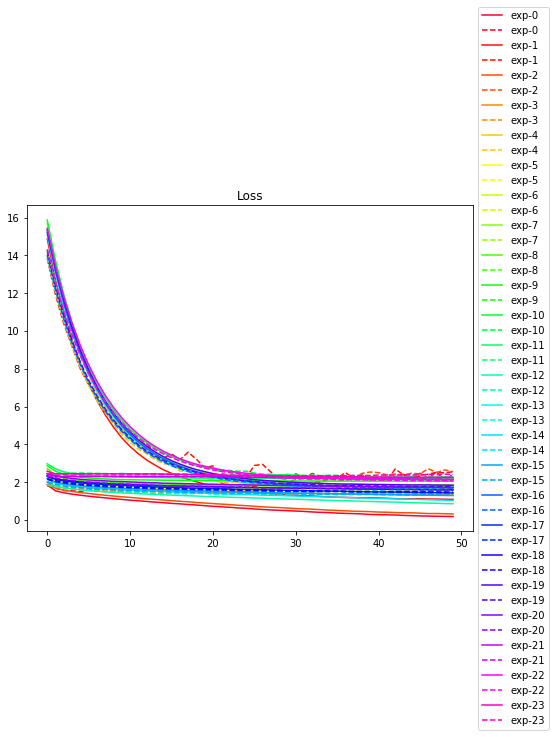

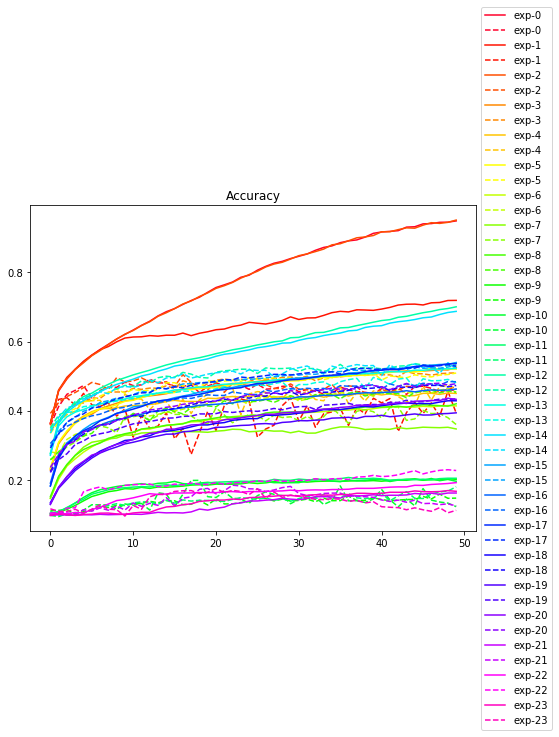

In [20]:
# 顏色數 要和前面的 嘗試參數組合數 一樣
import matplotlib.colors as colors
import matplotlib.cm as mplcm

NUM_COLORS = 24
cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

# plot
# loss
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# acc
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()